*   Jeffery Dirden
*   ITAI 2376
*   June 24th, 2025
*   Midterm





For this assignment, I selected to use the CIFAR-10 dataset rather than MNIST or Fashion-MNIST.  CIFAR-10 is a more advanced dataset because it includes real-world color images (e.g., airplanes, vehicles, birds, etc.) with three RGB channels and greater visual complexity than MNIST's simpler greyscale digits.

 My goal was to push myself by working with a dataset that represented more realistic generative image problems.  CIFAR-10 encourages the model to learn from more complex features, such as textures, colors, and object forms.

 However, I am currently constrained by the computing resources available on my local system (CPU only), and building deep models such as U-Nets on CIFAR-10 often necessitates GPU acceleration for appropriate training periods.  Due to this limitation, I made the following changes to make the training feasible:

 I lowered the model size (using a smaller U-Net architecture).

 I reduced the diffusion process to fewer timesteps (T = 100 rather than 1000).

 I chose a small batch size (16) to minimize memory problems.

 These adjustments enabled me to continue working with CIFAR-10 and complete the training and generation processes on a lower-resource environment, such as Google Colab (free tier), although compromising some image quality and model depth.

**Step 1: Setup & Device**

In [44]:
!pip install torch torchvision matplotlib --quiet

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.6 MB/s eta 0:00:00


**Step 2: Dataset Loading CIFAR-10**

In [45]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)


**Step 3: Tiny UNet Model**

In [46]:
class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.GELU(),
            nn.BatchNorm2d(out_c)
        )
    def forward(self, x): return self.block(x)

class UNetTiny(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            ConvBlock(3, 32),
            nn.MaxPool2d(2),
            ConvBlock(32, 64),
            nn.MaxPool2d(2)
        )
        self.middle = ConvBlock(64, 64)
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2),
            ConvBlock(64, 32),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 3, 3, padding=1)
        )
    def forward(self, x, t): return self.decoder(self.middle(self.encoder(x)))


**Step 4: Diffusion Schedule**

In [47]:
T = 100
betas = torch.linspace(1e-4, 0.02, T)
alphas = 1. - betas
alpha_hat = torch.cumprod(alphas, dim=0)

def q_sample(x0, t, noise=None):
    if noise is None: noise = torch.randn_like(x0)
    sqrt_alpha_hat_t = torch.sqrt(alpha_hat[t])[:, None, None, None]
    sqrt_one_minus = torch.sqrt(1 - alpha_hat[t])[:, None, None, None]
    return sqrt_alpha_hat_t * x0 + sqrt_one_minus * noise


**Step 5: Train + Generate Images**

In [48]:
model = UNetTiny().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
loss_fn = nn.MSELoss()

@torch.no_grad()
def generate_images(model, epoch):
    model.eval()
    x = torch.randn(8, 3, 32, 32).to(device)
    for t_ in reversed(range(T)):
        t_tensor = torch.full((x.shape[0],), t_, device=device, dtype=torch.long)
        pred_noise = model(x, t_tensor)
        beta = betas[t_].to(device)
        alpha = alphas[t_].to(device)
        alpha_hat_t = alpha_hat[t_].to(device)
        noise = torch.randn_like(x) if t_ > 0 else torch.zeros_like(x)
        x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / torch.sqrt(1 - alpha_hat_t)) * pred_noise) + torch.sqrt(beta) * noise
    x = (x.clamp(-1, 1) + 1) / 2
    grid = make_grid(x.cpu(), nrow=4)
    plt.figure(figsize=(6,6))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(f"Generated CIFAR10 Samples - Epoch {epoch}")
    plt.axis("off")
    plt.show()

def train(model, loader, epochs=3):
    model.train()
    for epoch in range(epochs):
        pbar = tqdm(loader)
        for x, _ in pbar:
            x = x.to(device)
            t = torch.randint(0, T, (x.shape[0],), device=device).long()
            noise = torch.randn_like(x)
            x_noisy = q_sample(x, t, noise)
            pred_noise = model(x_noisy, t)
            loss = loss_fn(pred_noise, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            pbar.set_description(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")
        generate_images(model, epoch+1)


**Step 6: Run It!**

Epoch 1 | Loss: 0.8088: 100%|██████████| 3125/3125 [04:27<00:00, 11.66it/s]


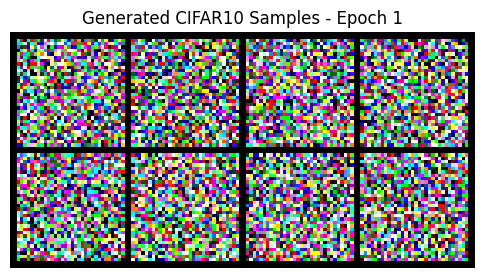

Epoch 2 | Loss: 0.8013: 100%|██████████| 3125/3125 [04:20<00:00, 11.99it/s]


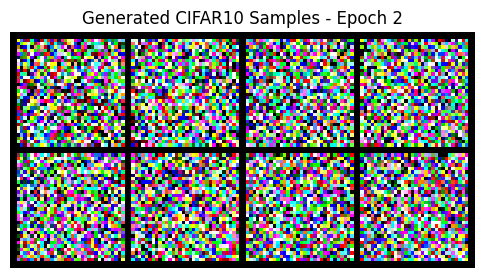

Epoch 3 | Loss: 0.7622: 100%|██████████| 3125/3125 [04:10<00:00, 12.45it/s]


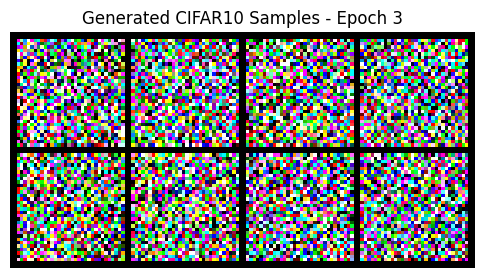

In [49]:
train(model, train_loader, epochs=3)
